# Analyse Rating

Fragen:

- Hat die Transaktionsbewertung Einfluss auf die wirtschaftliche Leistung?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

Datenaufbereitung von Patrick


In [3]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [4]:
df_reg_main.head(100000)

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2022-03-08,Tablet Pro,1.0,3,0,0,1,NaN,NaN,800.24,...,10,800.24,2400.72,999,2997,198.76,596.28,7.6,B,store
99996,2022-03-08,Tablet Pro,1.0,3,0,0,1,NaN,NaN,840.25,...,10,840.25,2520.75,999,2997,158.75,476.25,7.4,B,store
99997,2022-03-08,Tablet Pro,1.0,1,0,0,1,NaN,NaN,840.25,...,10,840.25,840.25,999,999,158.75,158.75,8.2,B,store
99998,2022-03-08,Tablet Pro,1.0,1,0,0,1,NaN,NaN,840.25,...,10,840.25,840.25,999,999,158.75,158.75,8.1,B,store


In [5]:
df_reg_main.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,year,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating
count,335253,300164.000000,335253.000000,335253.000000,335253.000000,335253.000000,75253.000000,110000.00000,150000.000000,335253.000000,335253.000000,335253.000000,335253.0,335253.000000,335253.000000,335253.00000,335253.000000,335253.000000,335253.000000,335253.000000
mean,2022-05-13 00:24:06.816583424,0.988871,2.405234,0.224466,0.328110,0.447423,286.214998,211.65353,855.001512,170761.352584,2021.858853,6.574745,26.73928,516.238937,1162.729318,748.38011,1739.700176,232.141173,576.970857,7.587594
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.02000,486.090000,0.000000,2021.000000,1.000000,1.0,136.020000,136.020000,499.00000,499.000000,-186.370000,-2050.070000,1.600000
25%,2022-02-13 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,215.000000,171.57000,805.340000,85937.000000,2022.000000,4.000000,14.0,206.730000,447.340000,550.00000,999.000000,133.130000,215.940000,6.700000
50%,2022-05-18 00:00:00,1.000000,2.000000,0.000000,0.000000,0.000000,276.590000,196.21000,859.115000,171144.000000,2022.000000,7.000000,27.0,349.530000,862.610000,680.00000,1497.000000,230.190000,392.620000,7.700000
75%,2022-08-13 00:00:00,1.000000,3.000000,0.000000,1.000000,1.000000,344.040000,259.94000,909.410000,255788.000000,2022.000000,9.000000,39.0,847.510000,1705.780000,999.00000,2116.000000,350.620000,768.750000,8.700000
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,685.370000,326.26000,985.000000,339999.000000,2022.000000,12.000000,52.0,985.000000,9557.520000,999.00000,12987.000000,512.910000,7110.600000,10.000000
std,NaN,0.031449,1.579624,0.417231,0.469526,0.497229,86.871362,51.42493,73.858664,98109.396928,0.348174,3.329539,14.505512,314.110280,939.646248,228.49302,1125.267154,120.618094,548.731709,1.580079


Wie verhält sich das Rating bei den unterschiedlichen Modellen? -> Tablet Basic ist wohl deutlich unbeliebter

Erklärung Boxplot:

- Die zentrale Linie in jeder Box zeigt den Median der Bewertungen an.
- Die Kanten der Box zeigen das untere (25. Perzentil) und obere (75. Perzentil) Quartil der Daten.
- Die "Whisker" (vertikalen Linien, die aus der Box herausragen) erstrecken sich bis zu den am weitesten entfernten Punkten, die keine Ausreißer sind.
- Punkte, die als Ausreißer gelten (weit entfernt von den Quartilen), werden als individuelle Punkte dargestellt.


c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


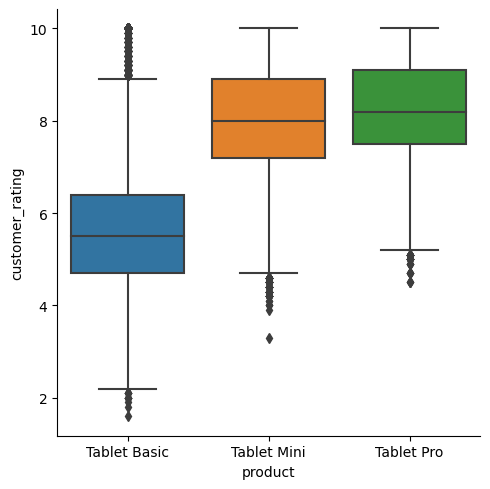

In [11]:
sns.catplot(data=df_reg_main, x="product", y="customer_rating", 
kind="box")

Wie verhält sich das Rating bezogen auf die Regionen und den Marktplatz?

- Die Ratings für Phone und Store sind generell höher, haben aber einige Ausreißer nach unten.
- Dadurch, dass die Online-Ratings im Schnitt generell niedriger sind, gibt es bei Online keine Ausreißer.

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


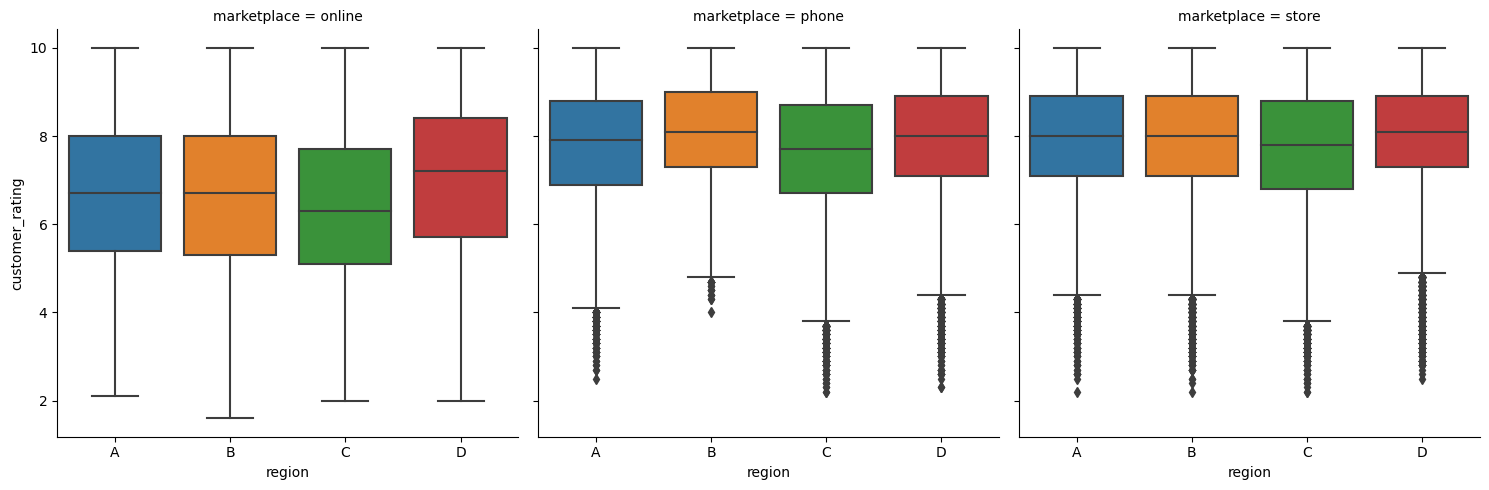

In [12]:
sns.catplot(data=df_reg_main, x="region", y="customer_rating", col="marketplace", 
kind="box")

Wie verändert sich das Rating über die Zeit? -> Spike im 10. Monat, warum?

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


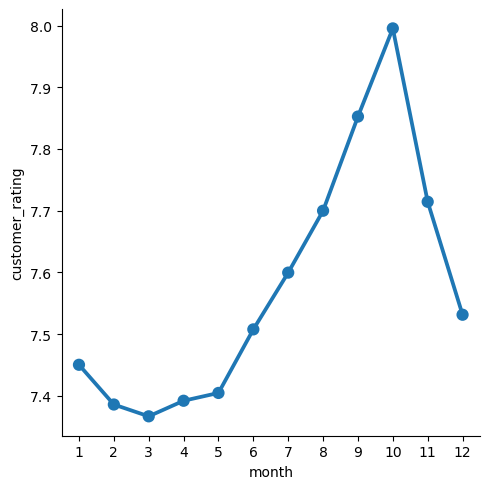

In [14]:
sns.catplot(data=df_reg_main, x="month", y="customer_rating", kind="point", errorbar=None);

Wie verhält sich das durschnittliche Rating über die Zeit, gruppiert nach Marktplatz? -> aufällig ist, das Online im 5. Monat am niedrigsten ist

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


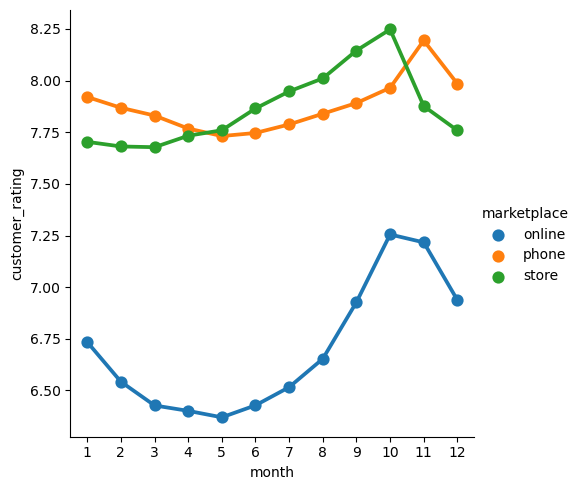

In [9]:
sns.catplot(data=df_reg_main, x="month", y="customer_rating", kind="point", hue="marketplace", errorbar=None);

Wie verhält sich das durschnittliche Rating über die Zeit, gruppiert nach Produkt? Das Rating von Basic sinkt kontinuirlich, und steigt dann auf einmal wieder...

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


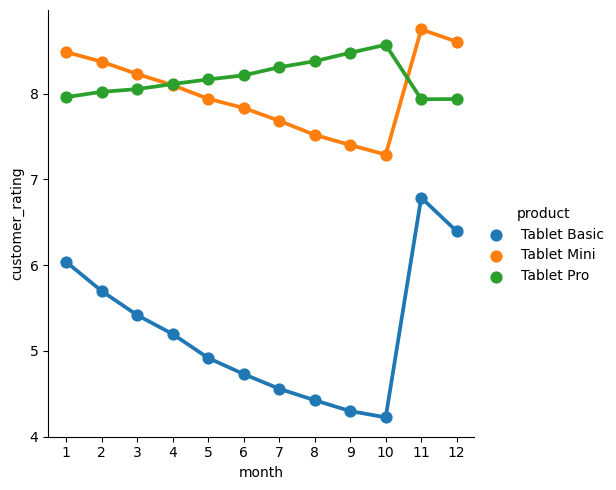

In [10]:
sns.catplot(data=df_reg_main, x="month", y="customer_rating", kind="point", hue="product", errorbar=None);